<a href="https://colab.research.google.com/github/DurjoyAcharya/breast-cancer-detection/blob/main/BR_CANCER_SM_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation Model


In [5]:
!pip install -U -q segmentation-models

In [3]:
import pandas as pd
from glob import glob
import tensorflow as tf
print(tf.__version__)
import tensorflow.image as tfi


from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import keras

from keras.utils import normalize
from keras.metrics import MeanIoU

import os
import keras
import numpy as np

2.15.0
Segmentation Models: using `tf.keras` framework.


In [6]:
from glob import glob
n_classes=2 #Number of classes for segmentation
SIZE=128

def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    labels = []  # List to store labels

    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img
            # Assign labels based on the class name in the path
            if 'benign' in image:
                labels.append(0)  # Label 0 for 'benign'
            elif 'malignant' in image:
                labels.append(1)  # Label 1 for 'malignant'
            elif 'normal' in image:
                labels.append(2)  # Label 2 for 'normal'

    labels = np.array(labels)  # Convert labels to NumPy array

    return images, labels


def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    if len(mask.shape) == 2:
        mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')



import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the target directory where you want to extract the contents
root_path = "/content/drive/MyDrive/CSproj/Dataset/"


#classes = sorted(os.listdir(root_path))

classes = ['benign', 'malignant', 'normal']
classes.remove('normal')



single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])


image_paths = []
mask_paths = []

for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

images, labels = load_images(image_paths, SIZE)
masks, _ = load_images(mask_paths, SIZE, mask=True)

import os
from glob import glob
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
SIZE = (128, 128)
BATCH_SIZE = 32

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.3, random_state = 0)
labels_train, labels_test = train_test_split(labels, test_size=0.3, random_state=0)

import cv2
import numpy as np
import tensorflow as tf


def dataAugmentation(images, masks, labels, target_size=(128, 128)):
    imagesupdate = []
    masksupdate = []
    benign_indices = np.where(labels == 0)[0]  # Get indices of the benign class
    malignant_indices = np.where(labels == 1)[0]  # Get indices of the malignant class

    # Append all benign class images without augmentation
    for idx in benign_indices:
        image = images[idx]
        mask = masks[idx]
        imageup = cv2.resize(image, target_size)
        maskup = cv2.resize(mask, target_size)
        imagesupdate.append(imageup)
        masksupdate.append(maskup)

    # Perform augmentation for the malignant class
    for idx in malignant_indices:
        image = images[idx]
        mask = masks[idx]
        for aug in range(8):  # Updated to include contrast adjustment
            imageup = cv2.resize(image, target_size)  # Resize the image
            maskup = cv2.resize(mask, target_size)    # Resize the mask
            if aug == 1:
                # Random rotation between -25 and 25 degrees
                angle = np.random.uniform(-45, 45)
                rows, cols = imageup.shape[:2]
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
                imageup = cv2.warpAffine(imageup, M, (cols, rows))
                maskup = cv2.warpAffine(maskup, M, (cols, rows))
            elif aug == 2:
                # Random horizontal flip
                imageup = cv2.flip(imageup, 1)
                maskup = cv2.flip(maskup, 1)
            elif aug == 3:
                # Random vertical flip
                imageup = cv2.flip(imageup, 0)
                maskup = cv2.flip(maskup, 0)
            elif aug == 4:
                # Zoom augmentation
                zoom_factor = np.random.uniform(1, 2)  # Adjust the zoom factor as needed
                zoomed_image = cv2.resize(imageup, None, fx=zoom_factor, fy=zoom_factor)
                zoomed_mask = cv2.resize(maskup, None, fx=zoom_factor, fy=zoom_factor)
                new_rows, new_cols = target_size[0], target_size[1]
                start_row = (zoomed_image.shape[0] - new_rows) // 2
                start_col = (zoomed_image.shape[1] - new_cols) // 2
                imageup = zoomed_image[start_row:start_row + new_rows, start_col:start_col + new_cols]
                maskup = zoomed_mask[start_row:start_row + new_rows, start_col:start_col + new_cols]
            elif aug == 5:
                # Shear augmentation
                shear_factor = np.random.uniform(-0.5, 0.5)  # Adjust the shear factor as needed
                rows, cols = imageup.shape[:2]
                shear_matrix = np.array([[1, shear_factor, 0], [0, 1, 0]], dtype=np.float32)
                imageup = cv2.warpAffine(imageup, shear_matrix, (cols, rows))
                maskup = cv2.warpAffine(maskup, shear_matrix, (cols, rows))
            elif aug == 6:
                # Brightness adjustment
                brightness_factor = np.random.uniform(0.5, 2.0)  # Adjust the brightness factor as needed
                imageup = cv2.convertScaleAbs(imageup, alpha=brightness_factor, beta=0)
            elif aug == 7:
                # Contrast adjustment
                contrast_factor = np.random.uniform(0.5, 1.5)  # Adjust the contrast factor as needed
                imageup = cv2.convertScaleAbs(imageup, alpha=contrast_factor, beta=0)
            else:
                # No augmentation, just append the original image and mask
                pass

            imagesupdate.append(imageup)
            masksupdate.append(maskup)

    return np.array(imagesupdate), np.array(masksupdate)




X_train, y_train= dataAugmentation(X_train, y_train, labels_train)
print("Train images shape after augmentation:", X_train.shape)
print("Train masks shape after augmentation:", y_train.shape)




print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

threshold = 0.5  # Adjust this threshold as needed
# Assuming you have your masks in the 'masks' array
y_train = (y_train > threshold).astype(int)
y_test = (y_test > threshold).astype(int)
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled



from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
print(y_train_cat.shape)


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

######################################################
#Reused parameters in all models

n_classes=2
activation='sigmoid'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (background: 0.2 ; tumor: 0.8)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.2, 0.8]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (0.5 * focal_loss)


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

threshold = 0.5  # Adjust this threshold as needed
# Assuming you have your masks in the 'masks' array
y_train = (y_train > threshold).astype(int)
y_test = (y_test > threshold).astype(int)
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled



from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
print(y_train_cat.shape)


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

######################################################
#Reused parameters in all models

n_classes=2
activation='sigmoid'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (background: 0.2 ; tumor: 0.8)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.2, 0.8]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (0.5 * focal_loss)


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

Train images shape after augmentation: (1404, 128, 128, 3)
Train masks shape after augmentation: (1404, 128, 128)
Class values in the dataset are ...  [0.00000000e+00 1.36405776e-06 3.81409291e-06 ... 9.99998641e-01
 9.99998779e-01 1.00000000e+00]
Class values in the dataset are ...  [0 1]
(1404, 128, 128, 2)
Class values in the dataset are ...  [0 1]
Class values in the dataset are ...  [0 1]
(1404, 128, 128, 2)


In [8]:
# from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.image import resize
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
#from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
import keras.backend as K




#DICE METRIC
def dice_metric(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

#iou METRIC
def iou_metric(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + 1.) / (union + 1.)


def f1_score(y_true, y_pred):
    # Calculate true positives, false positives, and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score


# Choose the backbone (e.g., 'resnet18' or 'resnet34')
BACKBONE = 'resnet18'

# Get the preprocessing function for the selected backbone
preprocess_input = get_preprocessing(BACKBONE)

# Preprocess input data using the backbone's preprocessing function
X_train_processed = preprocess_input(X_train)
X_test_processed = preprocess_input(X_test)

# Resize ground truth labels to match the model output size (128x128)
#_train_resized = resize(y_train, [128, 128])  # Adjust dimensions to match model output
#_test_resized = resize(y_test, [128, 128])  # Adjust dimensions to match model output


from skimage.transform import resize

# Example code to resize each sample in y_train to match the model's output shape
y_train_resized = np.zeros((y_train.shape[0], 128, 128))  # Initialize an array to store resized masks

for i in range(y_train.shape[0]):
    y_train_resized[i] = resize(y_train[i], (128, 128), preserve_range=True)

# Check the shape of y_train_resized
print(y_train_resized.shape)


from skimage.transform import resize

# Initialize an array to store resized masks
y_test_resized = np.zeros((y_test.shape[0], 128, 128))

for i in range(y_test.shape[0]):
    resized_mask = resize(y_test[i], (128, 128), preserve_range=True)

    # If the resized mask has an extra channel (128x128x1), remove it
    if resized_mask.shape[-1] == 1:
        resized_mask = np.squeeze(resized_mask, axis=-1)

    y_test_resized[i] = resized_mask

# Check the shape of y_test_resized
print(y_test_resized.shape)



# Define the U-Net architecture
model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid',
    encoder_freeze=True
)


for layer in model.layers:
    if 'conv2d' in layer.name.lower():  # Add Dropout after Conv2D layers in the encoder
        model.add(Dropout(0.07))

weight_decay = 1e-4  # Adjust the weight decay parameter as needed
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.kernel_regularizer = regularizers.l2(weight_decay)



def iou_loss(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou  # Minimize (1 - IoU) as loss



gamma = 2.0  # Tunable focusing parameter

def focal_loss(y_true, y_pred):
    epsilon = 1e-9
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    focal_loss = -y_true * ((1 - y_pred) ** gamma) * tf.math.log(y_pred)
    return tf.reduce_mean(focal_loss, axis=-1)


# Compile the model with total_loss and optimizer
model.compile(optimizer = 'adam',
    metrics = [iou_metric, dice_metric,f1_score],
    #loss='binary_focal_crossentropy')
    #loss=total_loss)
    loss=iou_loss)

#print(model.summary())

from keras.callbacks import ReduceLROnPlateau
# Define a learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='dice_metric', patience=7, mode='max', verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_iou.h5',
                                                monitor='val_iou_metric',
                                                mode='max',
                                                save_best_only=True,
                                                verbose=1)



# Train the model using the preprocessed data
history = model.fit(
    X_train_processed,
    y_train_resized,  # Use resized ground truth labels
    #train_generator,
    batch_size=16,
    callbacks=[reduce_lr, early_stopping, checkpoint],
    epochs=50,
    verbose=1,
    validation_data=(X_test_processed, y_test_resized)  # Use resized ground truth labels for validation
)

(1404, 128, 128)
(195, 128, 128)
44920640/44920640 [==============================] - 0s 0us/step
Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.6777 - iou_metric: 0.3228 - dice_metric: 0.4801 - f1_score: 0.5166
Epoch 1: val_iou_metric improved from -inf to 0.09962, saving model to best_model_iou.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 397s 4s/step - loss: 0.6777 - iou_metric: 0.3228 - dice_metric: 0.4801 - f1_score: 0.5166 - val_loss: 0.8965 - val_iou_metric: 0.0996 - val_dice_metric: 0.1793 - val_f1_score: 0.1778 - lr: 0.0010
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 0.5087 - iou_metric: 0.4916 - dice_metric: 0.6556 - f1_score: 0.6659
Epoch 2: val_iou_metric improved from 0.09962 to 0.13048, saving model to best_model_iou.h5
88/88 [==============================] - 390s 4s/step - loss: 0.5087 - iou_metric: 0.4916 - dice_metric: 0.6556 - f1_score: 0.6659 - val_loss: 0.8644 - val_iou_metric: 0.1305 - val_dice_metric: 0.2290 - val_f1_score: 0.2295 - lr: 0.0010
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 0.4523 - iou_metric: 0.5474 - dice_metric: 0.7043 - f1_score: 0.7075
Epoch 3: val_iou_metric did not improve from 0.13048
88/88 [==============================] - 385s 4s/step - loss: 0.4523 - iou_metric: 0.5474 - dice_metric: 0.

In [9]:
import shutil

# Specify the path to the destination folder on Google Drive
drive_folder = '/content/drive/MyDrive/CSproj/'

# Save your model using shutil
shutil.copy('/content/best_model_iou.h5', drive_folder)
# List the contents of the Google Drive folder
!ls '/content/drive/MyDrive/CSproj/'



best_model_iou.h5  Dataset


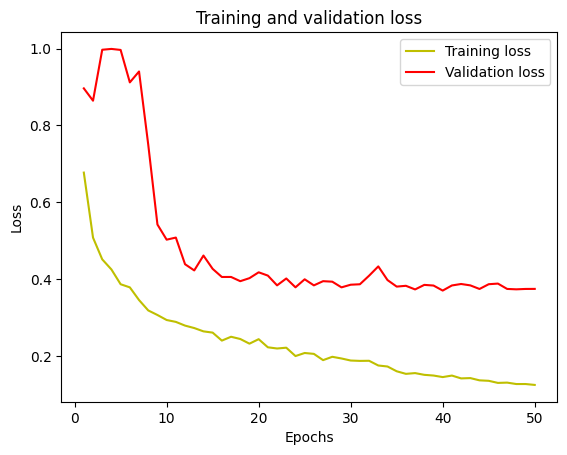

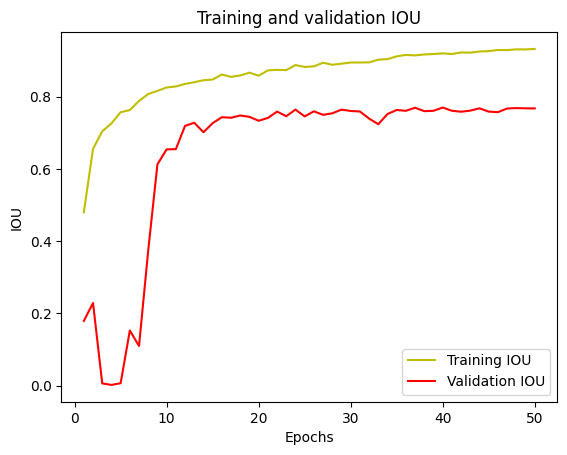

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_metric']
val_acc = history.history['val_dice_metric']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()


1/1 [==============================] - 1s 831ms/step
Avg IoU for image 3: 0.3958836896470346
1/1 [==============================] - 0s 88ms/step
Avg IoU for image 6: 0.7029943576345442
1/1 [==============================] - 0s 91ms/step
Avg IoU for image 9: 0.8299352987955174
1/1 [==============================] - 0s 90ms/step
Avg IoU for image 12: 0.7058790714031072
1/1 [==============================] - 0s 95ms/step
Avg IoU for image 15: 0.058322842437316204


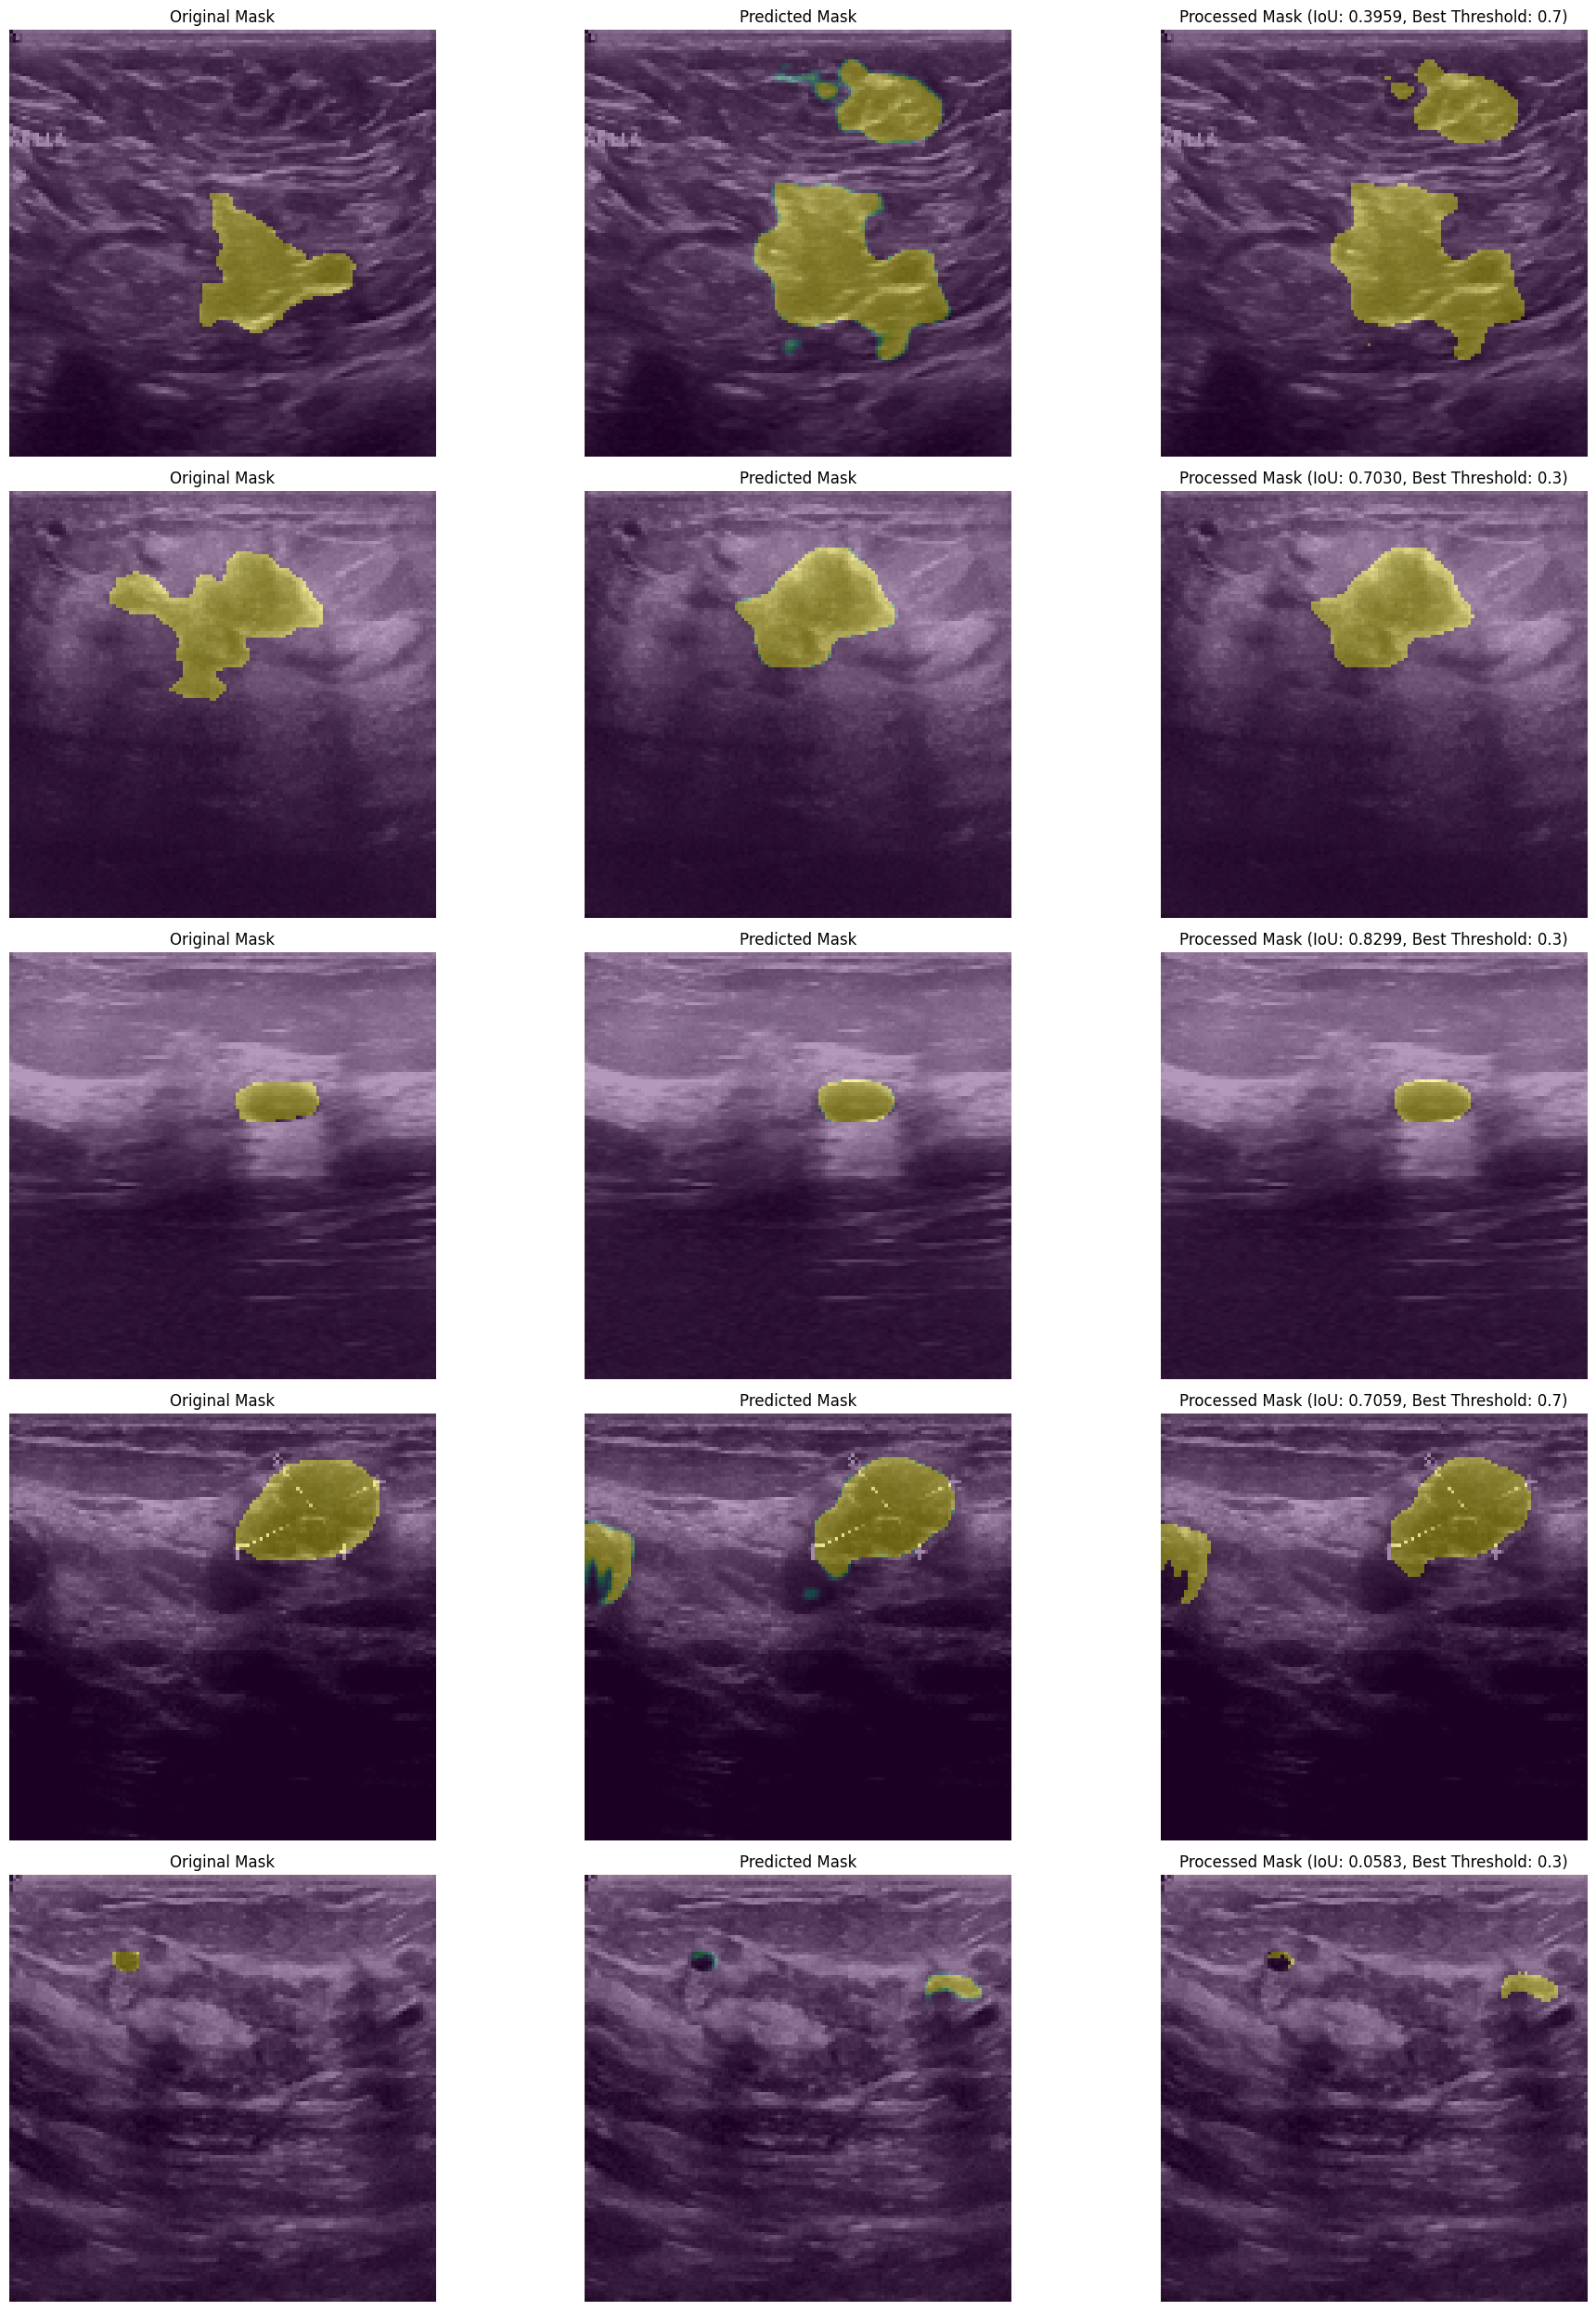

Best IoU: 0.8299352987955174 with threshold: 0.3


In [11]:
from sklearn.metrics import accuracy_score
from keras.models import load_model

best_model = load_model('best_model_iou.h5', compile=False)

def apply_threshold(pred_mask, threshold):
    processed_mask = (pred_mask > threshold).astype('float')
    return processed_mask


# Modify the code snippet as follows
plt.figure(figsize=(20, 25))
n = 0

best_iou = 0
best_threshold = 0

for i in range(1, (5 * 3) + 1):
    plt.subplot(5, 3, i)

    if n == 0:
        idx = np.random.randint(len(X_test))  # Randomly select an index from the test set
        image = X_test[idx]
        mask = y_test[idx]
        pred_mask = best_model.predict(image[np.newaxis, ...])  # Predict mask for the test image

        plt.title("Original Mask")
        show_mask(image, mask)
        n += 1
    elif n == 1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask[0])  # Display the predicted mask
        n += 1
    elif n == 2:
        thresholds = [0.3, 0.5, 0.7]  # Example thresholds to try
        iou_values = []

        for threshold in thresholds:
            processed_mask = apply_threshold(pred_mask[0], threshold)

            intersection = np.logical_and(mask, processed_mask).sum()
            union = np.logical_or(mask, processed_mask).sum()
            iou = intersection / union if union != 0 else 0

            iou_values.append(iou)

        avg_iou = np.mean(iou_values)
        print(f"Avg IoU for image {i}: {avg_iou}")

        best_idx = np.argmax(iou_values)
        best_threshold = thresholds[best_idx]
        best_processed_mask = apply_threshold(pred_mask[0], best_threshold)

        plt.title(f"Processed Mask (IoU: {avg_iou:.4f}, Best Threshold: {best_threshold})")
        show_mask(image, best_processed_mask)
        n = 0

        if avg_iou > best_iou:
            best_iou = avg_iou
            best_threshold = best_threshold

plt.tight_layout()
plt.show()

print(f"Best IoU: {best_iou} with threshold: {best_threshold}")


1/1 [==============================] - 1s 941ms/step
Avg IoU for image 3: 0.8502342683285594
1/1 [==============================] - 0s 147ms/step
Avg IoU for image 6: 0.0
1/1 [==============================] - 0s 153ms/step
Avg IoU for image 9: 0.7477380184847778
1/1 [==============================] - 0s 150ms/step
Avg IoU for image 12: 0.1597020334213919
1/1 [==============================] - 0s 149ms/step
Avg IoU for image 15: 0.7974035369642317


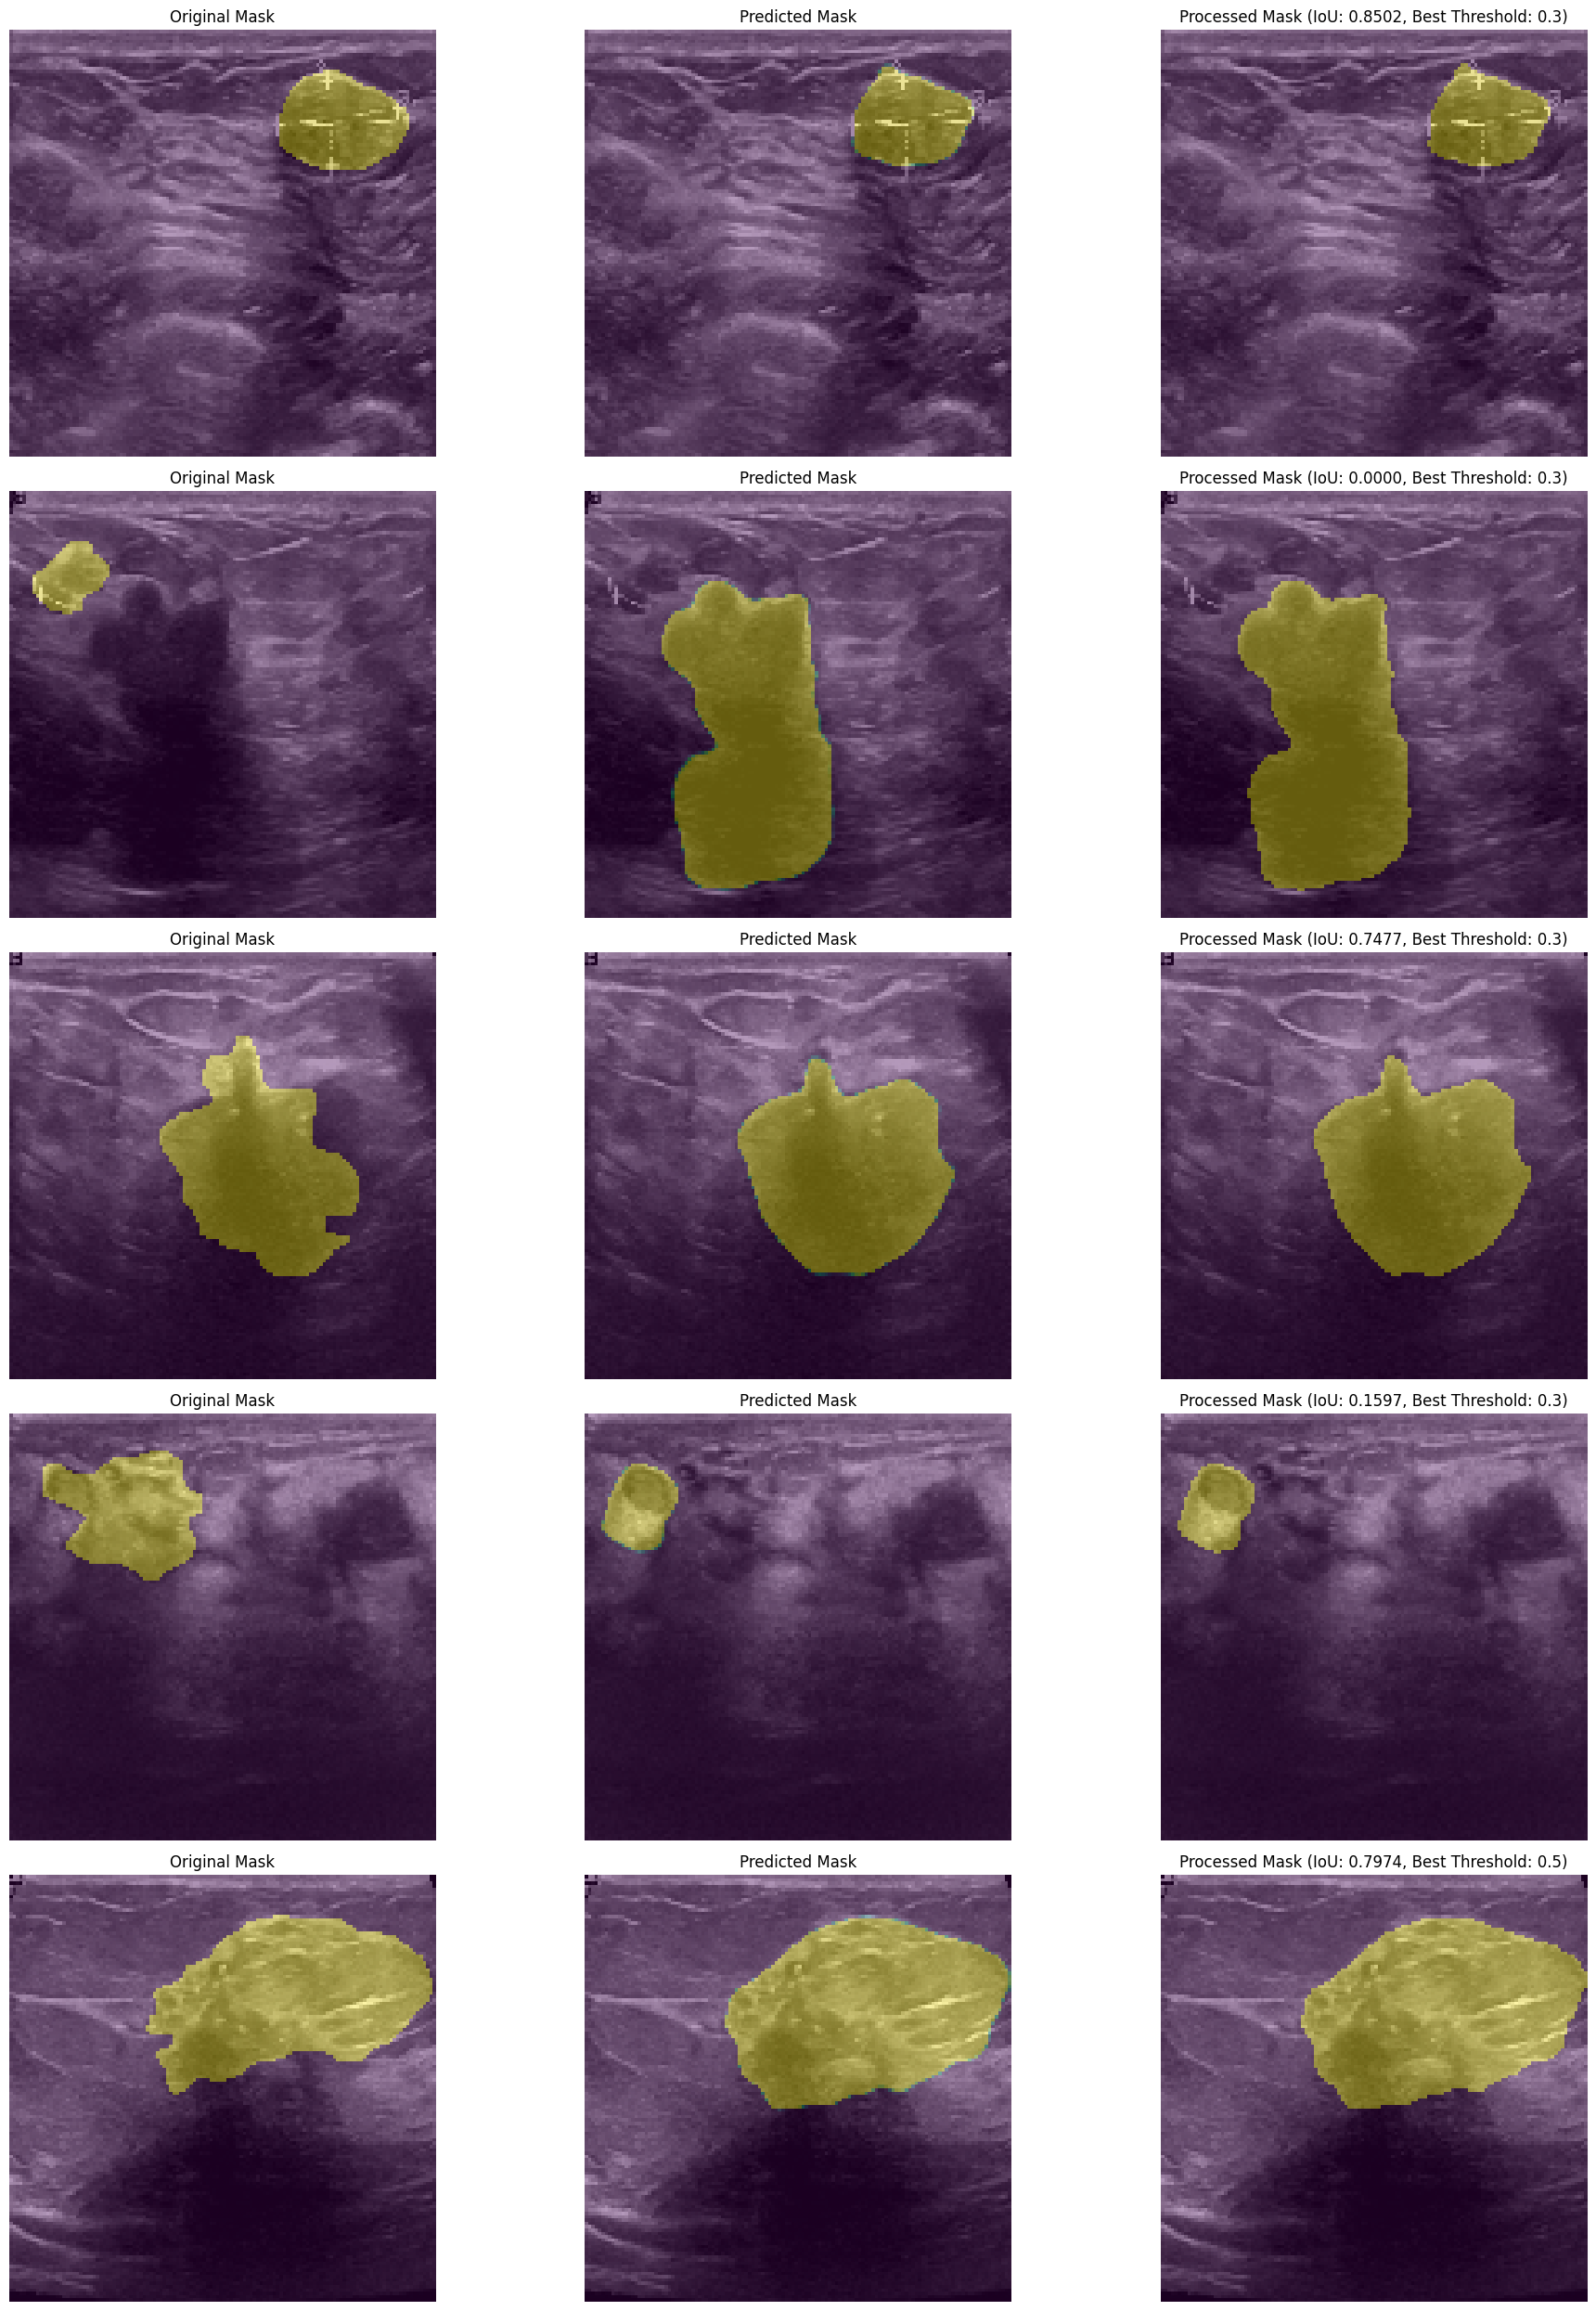

Best IoU: 0.8502342683285594 with threshold: 0.5


In [12]:
from sklearn.metrics import accuracy_score
from keras.models import load_model

best_model = load_model('best_model_iou.h5', compile=False)

def apply_threshold(pred_mask, threshold):
    processed_mask = (pred_mask > threshold).astype('float')
    return processed_mask


# Modify the code snippet as follows
plt.figure(figsize=(20, 25))
n = 0

best_iou = 0
best_threshold = 0

for i in range(1, (5 * 3) + 1):
    plt.subplot(5, 3, i)

    if n == 0:
        idx = np.random.randint(len(X_test))  # Randomly select an index from the test set
        image = X_test[idx]
        mask = y_test[idx]
        pred_mask = best_model.predict(image[np.newaxis, ...])  # Predict mask for the test image

        plt.title("Original Mask")
        show_mask(image, mask)
        n += 1
    elif n == 1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask[0])  # Display the predicted mask
        n += 1
    elif n == 2:
        thresholds = [0.3, 0.5, 0.7]  # Example thresholds to try
        iou_values = []

        for threshold in thresholds:
            processed_mask = apply_threshold(pred_mask[0], threshold)

            intersection = np.logical_and(mask, processed_mask).sum()
            union = np.logical_or(mask, processed_mask).sum()
            iou = intersection / union if union != 0 else 0

            iou_values.append(iou)

        avg_iou = np.mean(iou_values)
        print(f"Avg IoU for image {i}: {avg_iou}")

        best_idx = np.argmax(iou_values)
        best_threshold = thresholds[best_idx]
        best_processed_mask = apply_threshold(pred_mask[0], best_threshold)

        plt.title(f"Processed Mask (IoU: {avg_iou:.4f}, Best Threshold: {best_threshold})")
        show_mask(image, best_processed_mask)
        n = 0

        if avg_iou > best_iou:
            best_iou = avg_iou
            best_threshold = best_threshold

plt.tight_layout()
plt.show()

print(f"Best IoU: {best_iou} with threshold: {best_threshold}")
